In [ ]:
# Project 3 
                            
                           Automated Classification using Decision Trees

           This program gernerates a decision tree by the training dataset via ID3 algorithm, 
           and uses the tree to predict the test data outcomes.

In [2]:
import pandas as pd
import math

In [19]:
# construct dataframe from data file
# Pandas's dataframe is used for store dataset.
fishing = pd.read_csv('fishing.data',sep=' ', header = None, skiprows=8, 
     names = ["Wind", "Water", "Air", "Forecast","Oracle"])
     
fishing.index= range(0,len(fishing.index))   # change index

lenses = pd.read_csv('contact-lenses.data',sep=' ', header = None, skiprows=8, 
      names = ["age", "prescription", "astigmatism", "tearrate","Oracle"])
lenses.index = range(0,len(lenses.index))

In [4]:
fishing.head()

,Wind,Water,Air,Forecast,Oracle
0,Strong,Warm,Warm,Sunny,Yes
1,Weak,Warm,Warm,Sunny,No
2,Strong,Warm,Warm,Cloudy,Yes
3,Strong,Moderate,Warm,Rainy,Yes
4,Strong,Cold,Cool,Rainy,No


In [31]:
lenses

,age,prescription,astigmatism,tearrate,Oracle
0,young,myope,no,reduced,none
1,young,myope,no,normal,soft
2,young,myope,yes,reduced,none
3,young,myope,yes,normal,hard
4,young,hypermetrope,no,reduced,none
5,young,hypermetrope,no,normal,soft
6,young,hypermetrope,yes,reduced,none
7,young,hypermetrope,yes,normal,hard
8,pre-presbyopic,myope,no,reduced,none
9,pre-presbyopic,myope,no,normal,soft


In [6]:
# Calculate probability
def getProb(seri):
    prob = pd.Series()
    for key in seri.keys():
        prob[key]=seri[key]/seri.sum()
    return prob

In [7]:
# Calculate entropy    
def getEntr(seri):
    e = 0
    for key in seri.keys():
        e -= (seri[key]/seri.sum()) * math.log(seri[key]/seri.sum(),2)
    return e

In [8]:
# Calculate S    
def getBigS(dataframe):
    oracle = dataframe.Oracle.value_counts()
    total = oracle.sum()
    bigS = getEntr(oracle)
    return bigS,total

In [9]:
# Return the feature which has max information gain    
def maxGain(df):
    oracle = df.Oracle.value_counts()
    bisS,total = getBigS(df)
    features = df.columns.drop('Oracle')
    gain = pd.Series()
    for f in features:
        temp = df[[f,'Oracle']].groupby(f)
        entrophy = pd.Series()
        gain[f] = getEntr(oracle)
        for type in df[f].unique():
            temp2 = temp.get_group(type)['Oracle'].value_counts()
            entrophy[type] = getEntr(temp2)
            gain[f] -= temp2.sum()/total * entrophy[type]
    return gain.idxmax()

In [45]:
# Implement ID3 algorithm       
def createTree(tree,datafm):
    selFeature = maxGain(datafm)
    tree[selFeature]={}
    types = datafm[selFeature].value_counts()
    for key in types.keys():
        decision = datafm['Oracle'][datafm[selFeature]==key]
        #if all examples in S in the same class
        if len(decision.unique())==1:   
            decisionLeaf = decision.max()
        #return a leaf
            tree[selFeature][key]= decisionLeaf  
        #If there is no more attributes
        elif len(datafm.columns)<=2:    
            decisionLeaf = decision.max()
            tree[selFeature][key]= decisionLeaf
        else:
            tree[selFeature][key]={}  #Else recursively create the tree
            newdf = datafm[datafm[selFeature]==key].drop(selFeature,axis = 1)
            createTree(tree[selFeature][key],newdf)

In [11]:
def treeDict(datafm):
    tr = {}
    createTree(tr,datafm)
    return tr

In [49]:
# Get tree dictionary for dataset fishing and lenses:
fishingDict = treeDict(fishing)
lensesDict = treeDict(lenses)

In [50]:
fishingDict

{'Forecast': {'Cloudy': 'Yes',
  'Rainy': {'Air': {'Cool': 'No',
    'Warm': {'Wind': {'Strong': 'Yes', 'Weak': 'No'}}}},
  'Sunny': {'Wind': {'Strong': 'Yes',
    'Weak': {'Water': {'Cold': 'No', 'Moderate': 'Yes', 'Warm': 'No'}}}}}}

In [47]:
lensesDict

{'tearrate': {'normal': {'astigmatism': {'no': {'age': {'pre-presbyopic': 'soft',
      'presbyopic': {'prescription': {'hypermetrope': 'soft',
        'myope': 'none'}},
      'young': 'soft'}},
    'yes': {'prescription': {'hypermetrope': {'age': {'pre-presbyopic': 'none',
        'presbyopic': 'none',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'none'}}

In [40]:
#Visualize the tree
import pydotplus as pydot 

In [41]:
def plotDict(graph, treedict, parentNode=None):
    for k in treedict.keys():
        if parentNode is not None:
            from_name = parentNode.get_name() + '_' + str(k)
            from_label = str(k)
            node_from = pydot.Node(from_name, label=from_label)
            graph.add_node(node_from)
            graph.add_edge( pydot.Edge(parentNode, node_from) )
            if isinstance(treedict[k], dict):
                plotDict(graph, treedict[k], node_from)
            else: 
                to_name = str(k) + '_' + str(treedict[k])
                to_label = treedict[k]
                node_to = pydot.Node(to_name, label=to_label, shape='box')
                graph.add_node(node_to)
                graph.add_edge(pydot.Edge(node_from, node_to))
        else:
            from_name =  str(k)
            from_label = str(k)
            node_from = pydot.Node(from_name, label=from_label)
            plotDict(graph, treedict[k], node_from)

In [42]:
def plotTree(tree, name):
    graph = pydot.Dot(graph_type='digraph')
    plotDict(graph, tree)
    graph.write_png(name+'.png')

plotTree(fishingDict,'fishing')

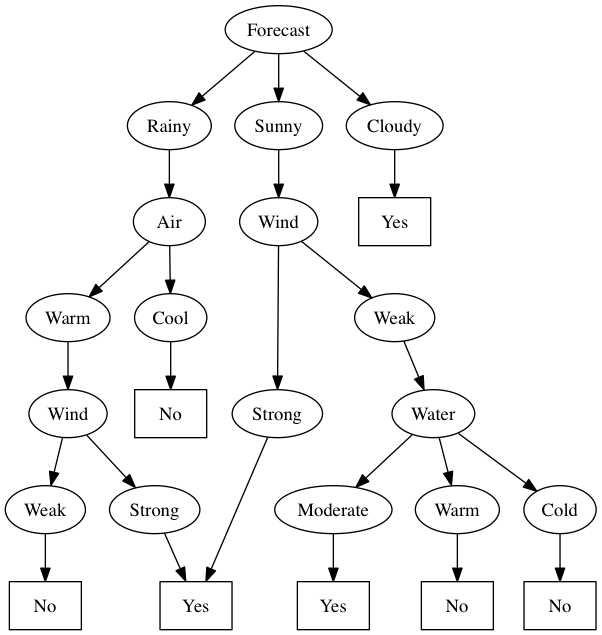

In [51]:
from IPython.display import Image
Image(filename='fishing.png') 

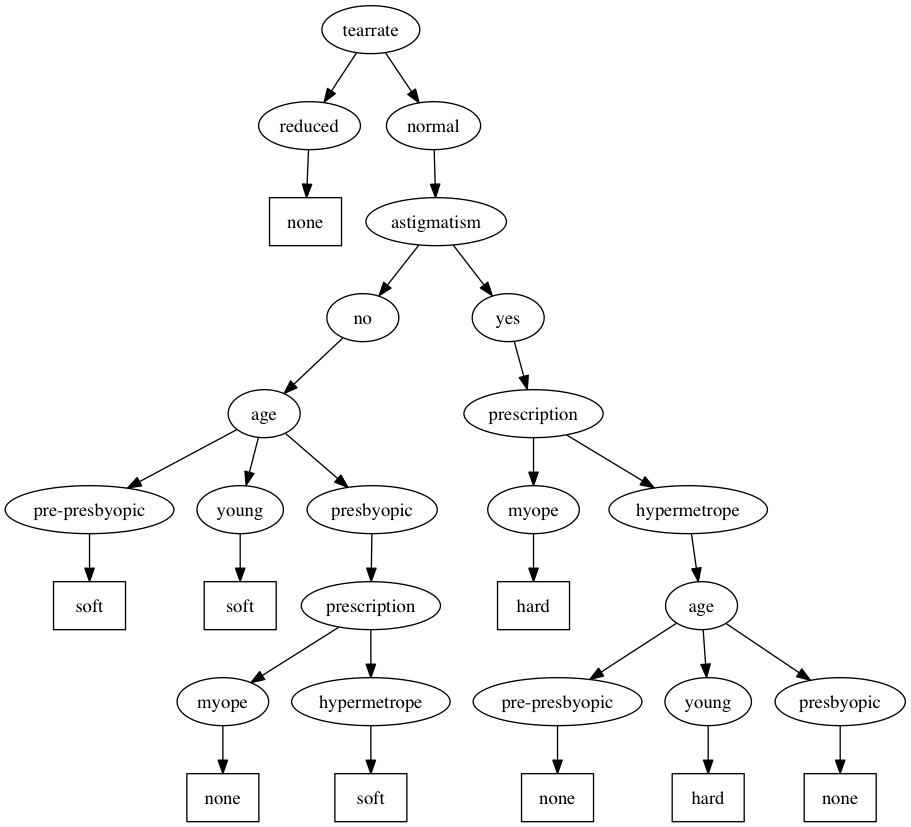

In [48]:
plotTree(lensesDict,"lenses")
Image(filename='lenses.png') 

In [52]:
# try more dataset: https://archive.ics.uci.edu/ml/datasets/Balloons
balloon_s = pd.read_csv( 'yellow-small+adult-stretch.data',sep=',', header = None,index_col=False,
                     names = ['color','size','act','age','Oracle'])

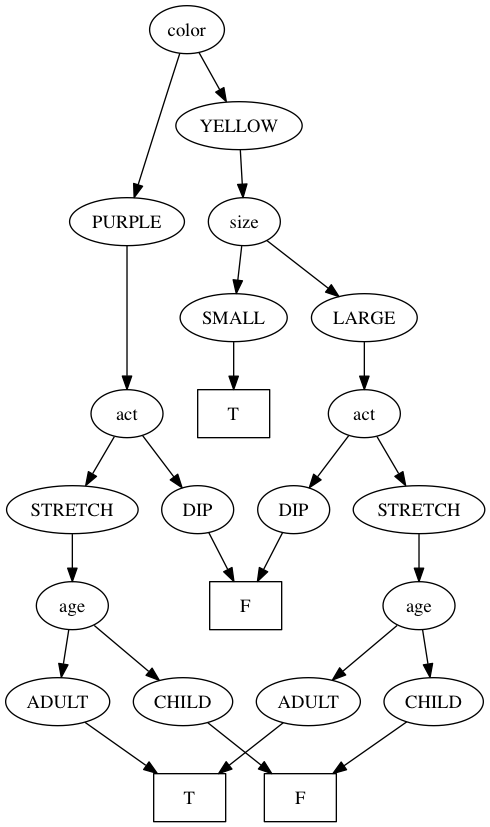

In [53]:
balloonsDict = treeDict(balloon_s)
plotTree(balloonsDict,'ysb')
Image(filename='ysb.png')

In [55]:
#Classify the test dataset by tree dictionary
# get single row
def splitRow(datafm):
    a = {}
    for i in datafm.index:
        a[i] = datafm.ix[i]
    return a
# Predict outcome for one row data
def classify(treeDict, testrow):
    for k in treeDict.keys(): 
        selFeat = k
        testval = testrow[selFeat]
        if testval not in treeDict[selFeat].keys(): 
            print("Error..")
        else:
            outcome = treeDict[selFeat][testval] 
            if type(outcome) == dict:
                return classify(outcome,testrow)
            else:
                return outcome
                
# Predict the outcomes for the whole dataset      
def classifyDF (treeDict,testdf):
    testrow = splitRow(testdf)
    predict ={}
    err = 0
    for key in testrow.keys():
        label = testrow[key]['Oracle']
        print("Label: ",label) 
        predict[key] = classify(treeDict, testrow[key])
        print("Predict outcome is: ", predict[key])
        print("\n")
        if str(predict[key]) != str(label):
            err+=1
    errrate = float(err / len(testrow.keys()))*100
    print("Error rate:", errrate)

In [21]:
import numpy as np

In [27]:
# Radomly create test set of fishing dataset
msk1 = np.random.rand(len(lenses)) < 0.8
test_lenses = lenses[~msk1]
train_lenses = lenses[msk1]

In [28]:
len(test_lenses)

3

In [24]:
# get tree dictionary for future predict
lensesDict = treeDict(train_lenses)

In [25]:
classifyDF (lensesDict,test_lenses)  

NameError: name 'classifyDF' is not defined

In [57]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
car = pd.read_csv('car.data',sep=',', header = None, skiprows=8, 
     names = ["buying", "maint", "doors", "persons","lug_boot","safety","Oracle"])     
car.index= range(0,len(car.index)) 

In [58]:
car.head()

,buying,maint,doors,persons,lug_boot,safety,Oracle
0,vhigh,vhigh,2,2,big,high,unacc
1,vhigh,vhigh,2,4,small,low,unacc
2,vhigh,vhigh,2,4,small,med,unacc
3,vhigh,vhigh,2,4,small,high,unacc
4,vhigh,vhigh,2,4,med,low,unacc


In [59]:
# Radomly create test set of car dataset
msk = np.random.rand(len(car)) < 0.8
test_car = car[~msk]
train_car = car[msk]

In [60]:
carDict = treeDict(train_car)

In [61]:
len(train_car)    # number of training samples

1346

In [62]:
len(test_car)     #number of test samples

374

In [63]:
classifyDF (carDict,test_car)    

Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  acc
Error..
Predict outcome is:  None


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  acc
Predict outcome is:  acc


Label:  unacc
Predict outcome is:  unacc


Label:  acc
Predict outcome is:  acc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  acc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  acc
Predict outcome is:  acc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  unacc
Predict outcome is:  unacc


Label:  acc
Predict 

In [ ]:
msk = np.random.rand(len(car)) < 0.8
test_car = car[~msk]
train_car = car[msk]

In [ ]:
carDict = treeDict(train_car)

In [ ]:
len(train_car)

In [ ]:
len(test_car)

In [ ]:
# Error rate for car dataset prediction
classifyDF (carDict,test_car) 

In [ ]:
# continuous attributes: 
# iris dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/
iris = pd.read_csv( 'iris.data',sep=',', header = None,index_col=False,
                     names = ['sepal_len','sepal_wid','petal_len','petal_wid','Oracle']) 

In [ ]:
iris.head()

In [ ]:
iris.describe()

In [ ]:
# choose the split point for each feature:
# sepal_len split pts[5.0,6.0,7.0]
# sepal_wid split pts[2.0,3.0,4.0]
# petal_len split pts[2.0,4.0,6.0]
# petal_wid split pts[0.8,1.6,2.4]
# reconstruct the new dataframe:
def newDF(oldDF,name,spp):
    temp1 = oldDF[oldDF[name]<spp[0]]
    temp1[name] = "<"+ str(spp[0])
    temp2 = oldDF[(oldDF[name]>=spp[0]) & (oldDF[name]<spp[1])]
    temp2[name] = str(spp[0])+"~"+ str(spp[1])
    temp3 = oldDF[(oldDF[name]>=spp[1]) & (oldDF[name]<spp[2])]
    temp3[name] = str(spp[1])+"~"+ str(spp[2])
    temp4 = oldDF[oldDF[name]>spp[2]]
    temp4[name] = ">"+ str(spp[2])   
    newDF = temp1.append(temp2).append(temp3).append(temp4)
    return newDF

In [ ]:
iris1 = newDF(iris,"sepal_len",[5.0,6.0,7.0])
iris2 = newDF(iris1,"sepal_wid",[2.0,3.0,4.0])
iris3 = newDF(iris2,"petal_len",[2.0,4.0,6.0])
newiris = newDF(iris3,"petal_wid",[0.8,1.6,2.4])

In [ ]:
newiris.tail()

In [ ]:
# randomly split the dataset into training data and test data:
rdm = np.random.rand(len(newiris)) < 0.8 
train_iris = newiris[rdm]
test_iris = newiris[~rdm]

In [ ]:
len(train_iris)

In [ ]:
# built iris tree dictionary
irisDict = treeDict(train_iris)

In [ ]:
classifyDF (irisDict,test_iris) 

In [ ]:
Discussion:
    1: The algorithmn used here could easily cause building a overfitting tree. For large dataset, 
       the tree plotting looks like spaghetti using this code.
    2: This model did not try to deal with missing values
    3: For unseen data prediction, error might occur when using classify method.
    4: The tree is not stable, it varies by the training data. The test error rate could be very high.
    6: Numeric valued training data need to split into proper points. Further study is needed for 
       choosing the best point
    5: Pruning method needs to further study also.

In [ ]:
plotTree(irisDict,"iris")

In [ ]:
# pydot has bug that can't plot out node name with some symbols like"~",">" and "."

In [56]:
classifyDF (lensesDict,lenses) 

Label:  none
Predict outcome is:  none


Label:  soft
Predict outcome is:  soft


Label:  none
Predict outcome is:  none


Label:  hard
Predict outcome is:  hard


Label:  none
Predict outcome is:  none


Label:  soft
Predict outcome is:  soft


Label:  none
Predict outcome is:  none


Label:  hard
Predict outcome is:  hard


Label:  none
Predict outcome is:  none


Label:  soft
Predict outcome is:  soft


Label:  none
Predict outcome is:  none


Label:  hard
Predict outcome is:  hard


Label:  none
Predict outcome is:  none


Label:  soft
Predict outcome is:  soft


Label:  none
Predict outcome is:  none


Label:  none
Predict outcome is:  none


Label:  none
Predict outcome is:  none


Label:  none
Predict outcome is:  none


Label:  none
Predict outcome is:  none


Label:  hard
Predict outcome is:  hard


Label:  none
Predict outcome is:  none


Label:  soft
Predict outcome is:  soft


Label:  none
Predict outcome is:  none


Label:  none
Predict outcome is:  none


Error rate: 0.0


In [29]:
lensesDict

{'tearrate': {'normal': {'astigmatism': {'no': 'soft',
    'yes': {'prescription': {'hypermetrope': 'none', 'myope': 'hard'}}}},
  'reduced': 'none'}}

In [ ]:
plotTree(lensesDict,"lenses")
Image(filename='lenses.png')